In [2]:
import pandas as pd
import json
import os
import regex as re

In [3]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7c0d01fc-7b60-4e72-b68e-769513f5d331;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 290ms :: artifacts dl 11ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

23/11/10 19:28:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/11/10 19:28:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/11/10 19:28:18 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
3.3.0


In [5]:
cwd = os.getcwd()
print(cwd)

/root/fall-2023-reddit-project-team-17/code


In [6]:
!aws s3 ls s3://project17-bucket-alex

                           PRE matt-comment-subreddit-counts/
                           PRE matt-submission-subreddit-counts/
                           PRE project_2022/
                           PRE project_2022_1/
                           PRE project_2022_10/
                           PRE project_2022_11/
                           PRE project_2022_12/
                           PRE project_2022_2/
                           PRE project_2022_3/
                           PRE project_2022_4/
                           PRE project_2022_5/
                           PRE project_2022_6/
                           PRE project_2022_7/
                           PRE project_2022_8/
                           PRE project_2022_9/
                           PRE project_jan2021/
                           PRE spark_logs/
2023-11-07 20:13:10       1216 eda_ideas.txt
2023-11-07 20:55:17         12 hello-from-victor.txt
2023-11-07 20:43:23         10 matt-test-file.txt


In [7]:
!aws s3 ls s3://project17-bucket-alex/project_2022_1/

                           PRE comments/
                           PRE submissions/


In [8]:
!aws s3 ls s3://project17-bucket-alex/project_jan2021/

                           PRE comments/
                           PRE submissions/


In [9]:
%%time
# Read in data from project bucket
bucket = "project17-bucket-alex"
#output_prefix_data = "project_2022"

# List of 12 directories each containing 1 month of data
directories = ["project_2022_"+str(i)+"/submissions" for i in range(1,13)]

# Iterate through 12 directories and merge each monthly data set to create one big data set
df_subs = None
for directory in directories:
    s3_path = f"s3a://{bucket}/{directory}"
    month_df = spark.read.parquet(s3_path, header = True)
    
    if df_subs is None:
        df_subs = month_df
    else:
        df_subs = df.union(month_df)

23/11/10 19:28:22 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


23/11/10 19:28:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


NameError: name 'df' is not defined

In [10]:
%%time
# Read in data from project bucket
bucket = "project17-bucket-alex"
#output_prefix_data = "project_2022"

# List of 12 directories each containing 1 month of data
directories = ["project_2022_"+str(i)+"/comments" for i in range(1,13)]

# Iterate through 12 directories and merge each monthly data set to create one big data set
df_comms = None
for directory in directories:
    s3_path = f"s3a://{bucket}/{directory}"
    month_df = spark.read.parquet(s3_path, header = True)
    
    if df_comms is None:
        df_comms = month_df
    else:
        df_comms = df_comms.union(month_df)

CPU times: user 12.8 ms, sys: 4.24 ms, total: 17 ms
Wall time: 5.49 s


In [11]:
#changed architecture and takes a long time
# df.describe().show()

In [12]:
df_subs.printSchema()

root
 |-- adserver_click_url: string (nullable = true)
 |-- adserver_imp_pixel: string (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- brand_safe: boolean (nullable = true)
 |-- contest_mode: boolean (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- crosspost_parent: string (nullable = true)
 |-- crosspost_parent_list: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- approved_at_utc: string (nullable = true)
 |    |    |-- approved_by: string (nullable = true)
 |    |    |-- archived: boolean (nullable = true)
 |    |    |-- author: string (nullable = true)
 |    |    |-- author_flair_css_class: string (nullable = true)
 |    |    |-- author_flair_text: string (nullable = true)
 |    |    

In [13]:
df_comms.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



In [14]:
df_comms.select(['subreddit', 'author', 'body', 'parent_id', 'link_id', 'id', 'created_utc', 'controversiality']).show(10)

+-----------------+--------------------+--------------------+----------+---------+-------+-------------------+----------------+
|        subreddit|              author|                body| parent_id|  link_id|     id|        created_utc|controversiality|
+-----------------+--------------------+--------------------+----------+---------+-------+-------------------+----------------+
|    AmItheAsshole|         beckydragon|                 NTA| t3_rz9uu3|t3_rz9uu3|hs0rusg|2022-01-10 04:49:57|               0|
|    AmItheAsshole|        Cactus_chuck|NTA. My partners ...| t3_s0baev|t3_s0baev|hs0rusr|2022-01-10 04:49:57|               0|
|    AmItheAsshole|   Red-belliedOrator|INFO\n\nIn genera...| t3_s0a5hn|t3_s0a5hn|hs0rut9|2022-01-10 04:49:57|               0|
|NoStupidQuestions|  SoMuchForLongevity|You couldn't heat...| t3_s0b5be|t3_s0b5be|hs0rutc|2022-01-10 04:49:57|               0|
|NoStupidQuestions|          MMmason651|it wouldn't taste...| t3_s0axsd|t3_s0axsd|hs0rutm|2022-01-10 04:

In [15]:
# from pyspark.ml.feature import Tokenizer, StopWordsRemover
# from pyspark.sql.functions import explode, col

# tokenizer = Tokenizer(inputCol="body", outputCol="words")
# df_words = tokenizer.transform(df_comms)

# remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
# df_filtered = remover.transform(df_words)

# df_exploded = df_filtered.withColumn("word", explode(col("filtered_words")))

# df_word_counts = df_exploded.groupBy("subreddit", "word").count()
# df_sorted = df_word_counts.sort(col("count").desc())

# df_sorted.show()

In [16]:
from pyspark.sql.functions import col, lower, sum

topics = ["covid", "ukraine", "russia", "trump", "biden", "vaccine", "insurrection", "afghanistan", "olympics"]

# Create a filter condition for each topic
condition = lower(col("body")).contains(topics[0])
for topic in topics[1:]:
    condition = condition | lower(col("body")).contains(topic)

df_filtered = df_comms.filter(condition)

# Count occurrences of each term in each subreddit
df_counts = df_filtered.groupBy("subreddit").agg(
    sum(lower(col("body")).contains(topics[0]).cast("int")).alias("covid_count"),
    sum(lower(col("body")).contains(topics[1]).cast("int")).alias("ukraine_count"),
    sum(lower(col("body")).contains(topics[2]).cast("int")).alias("russia_count"),
    sum(lower(col("body")).contains(topics[3]).cast("int")).alias("trump_count"),
    sum(lower(col("body")).contains(topics[4]).cast("int")).alias("biden_count"),
    sum(lower(col("body")).contains(topics[5]).cast("int")).alias("vaccine_count"),
    sum(lower(col("body")).contains(topics[6]).cast("int")).alias("insurrection_count"),
    sum(lower(col("body")).contains(topics[7]).cast("int")).alias("afghanistan_count"),
    sum(lower(col("body")).contains(topics[8]).cast("int")).alias("olympics_count")
)

df_counts.show()

+-------------------+-----------+-------------+------------+-----------+-----------+-------------+------------------+-----------------+--------------+
|          subreddit|covid_count|ukraine_count|russia_count|trump_count|biden_count|vaccine_count|insurrection_count|afghanistan_count|olympics_count|
+-------------------+-----------+-------------+------------+-----------+-----------+-------------+------------------+-----------------+--------------+
|     TrueOffMyChest|      15664|         7673|       12628|       5514|       2655|         4958|               150|             1007|           585|
|   unpopularopinion|      12592|        10089|       16112|       6840|       2221|         5657|               200|             1001|          2395|
|           antiwork|      68825|         7832|       18575|      32539|      26619|        10261|              1180|             2108|           619|
|       socialskills|       1123|           42|          93|        125|         21|          

In [18]:
pandas_df_counts = df_counts.toPandas()

In [27]:
pandas_df_counts.to_csv('df_counts.csv', index=False)

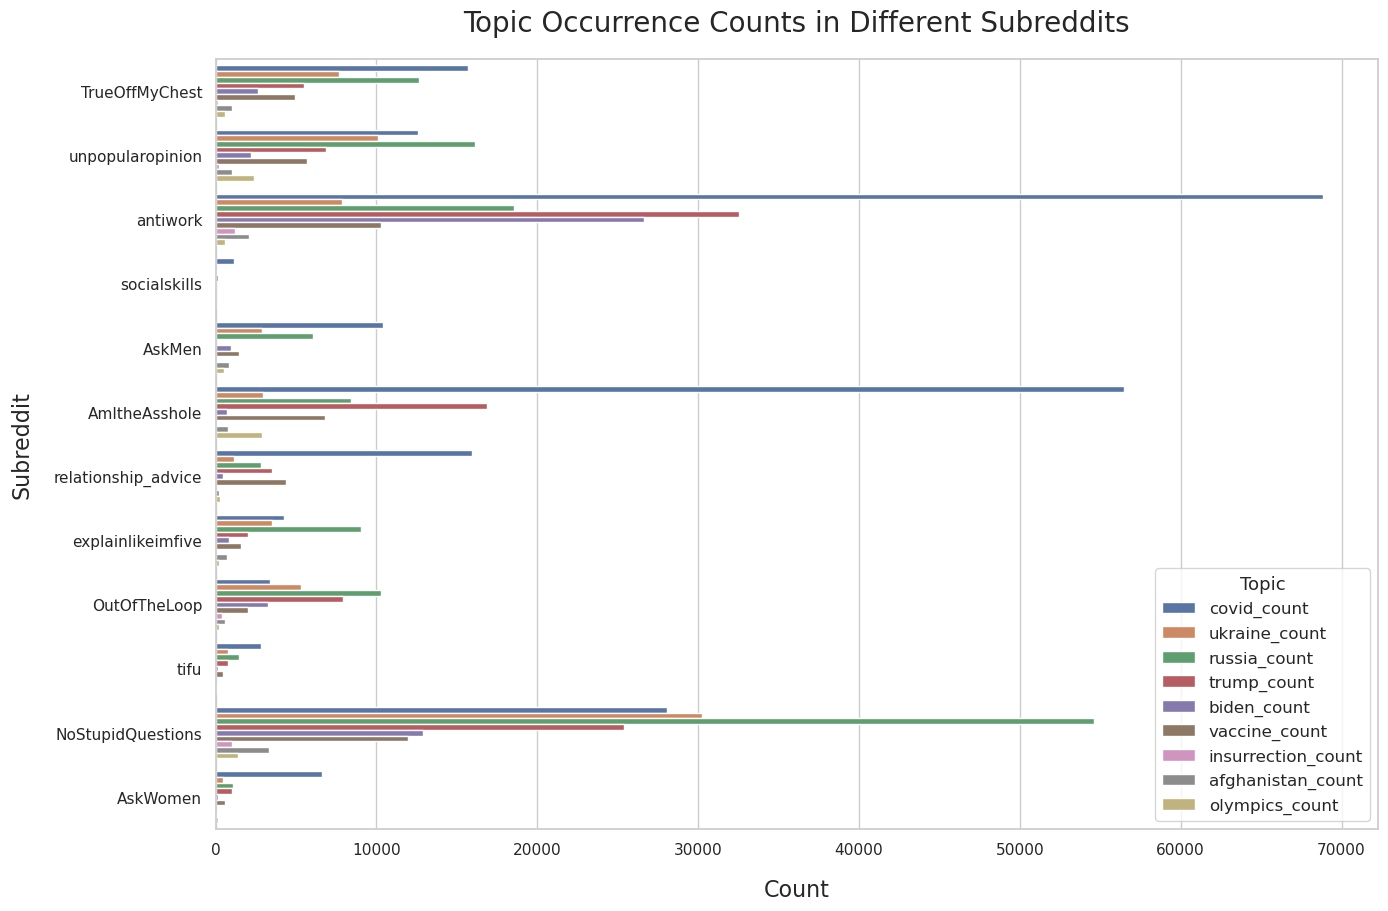

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the style of the visualization
sns.set(style="whitegrid")

# Prepare the data for plotting
# Reshape the DataFrame from wide format to long format
pandas_df_long = pd.melt(pandas_df_counts, id_vars=['subreddit'], var_name='Topic', value_name='Count')

# Create a stacked bar plot
plt.figure(figsize=(15, 10))
sns.barplot(x='Count', y='subreddit', hue='Topic', data=pandas_df_long, ci=None)

# Add labels and title
plt.xlabel("Count", fontsize=16, labelpad=15)
plt.ylabel("Subreddit", fontsize=16, labelpad=15)
plt.title("Topic Occurrence Counts in Different Subreddits", fontsize=20, pad=20)

plt.legend(title='Topic', title_fontsize='13', fontsize='12')

plt.savefig('../website-source/img/current-events.png')

# Show the plot
plt.show()

In [17]:
from pyspark.sql.functions import col, lower, sum, to_date

# Convert 'created_utc' to date format
df_filtered = df_filtered.withColumn("date", to_date(col("created_utc")))

# Group by subreddit and date, then count occurrences of each term
df_counts_by_date = df_filtered.groupBy("subreddit", "date").agg(
    sum(lower(col("body")).contains(topics[0]).cast("int")).alias("covid_count"),
    sum(lower(col("body")).contains(topics[1]).cast("int")).alias("ukraine_count"),
    sum(lower(col("body")).contains(topics[2]).cast("int")).alias("russia_count"),
    sum(lower(col("body")).contains(topics[3]).cast("int")).alias("trump_count"),
    sum(lower(col("body")).contains(topics[4]).cast("int")).alias("biden_count"),
    sum(lower(col("body")).contains(topics[5]).cast("int")).alias("vaccine_count"),
    sum(lower(col("body")).contains(topics[6]).cast("int")).alias("insurrection_count"),
    sum(lower(col("body")).contains(topics[7]).cast("int")).alias("afghanistan_count"),
    sum(lower(col("body")).contains(topics[8]).cast("int")).alias("olympics_count")
)

df_counts_by_date.show()


+-------------------+----------+-----------+-------------+------------+-----------+-----------+-------------+------------------+-----------------+--------------+
|          subreddit|      date|covid_count|ukraine_count|russia_count|trump_count|biden_count|vaccine_count|insurrection_count|afghanistan_count|olympics_count|
+-------------------+----------+-----------+-------------+------------+-----------+-----------+-------------+------------------+-----------------+--------------+
|               tifu|2022-01-18|         14|            0|           6|         14|          0|            8|                 0|                0|             0|
|   unpopularopinion|2022-01-09|         81|            3|          33|         19|         11|           48|                 0|               12|             2|
|             AskMen|2022-01-30|         43|            1|           6|          0|          0|           10|                 0|                3|             1|
|             AskMen|2022-01

In [20]:
pandas_df_counts_by_date = df_counts_by_date.toPandas()


In [26]:
pandas_df_counts_by_date.to_csv('counts_by_date.csv', index=False)

In [21]:
pandas_df_long = pandas_df_counts_by_date.melt(id_vars=["subreddit", "date"], 
                                               var_name="Topic", 
                                               value_name="Count")


In [23]:
!pip install altair

  Obtaining dependency information for altair from https://files.pythonhosted.org/packages/17/16/b12fca347ff9d062e3c44ad9641d2ec50364570a059f3078ada3a5119d7a/altair-5.1.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.2/516.2 kB 8.8 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [31]:
import altair as alt

# Enable the 'vegafusion' data transformer
alt.data_transformers.enable('vegafusion')

# Create a line chart
line_chart = alt.Chart(pandas_df_long).mark_line().encode(
    x='date:T',
    y='Count:Q',
    color='Topic:N',
    tooltip=['subreddit:N', 'date:T', 'Count:Q']
).properties(
    width=800,
    height=400
).interactive()

line_chart


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000).

Try enabling the VegaFusion data transformer which raises this limit by pre-evaluating data
transformations in Python.
    >> import altair as alt
    >> alt.data_transformers.enable("vegafusion")

Or, see https://altair-viz.github.io/user_guide/large_datasets.html for additional information
on how to plot large datasets.

alt.Chart(...)

In [29]:
pandas_df_counts.head()

,subreddit,covid_count,ukraine_count,russia_count,trump_count,biden_count,vaccine_count,insurrection_count,afghanistan_count,olympics_count
0,TrueOffMyChest,15664,7673,12628,5514,2655,4958,150,1007,585
1,unpopularopinion,12592,10089,16112,6840,2221,5657,200,1001,2395
2,antiwork,68825,7832,18575,32539,26619,10261,1180,2108,619
3,socialskills,1123,42,93,125,21,48,1,10,21
4,AskMen,10435,2898,6054,9,960,1483,99,820,527


In [30]:
pandas_df_counts_by_date.head()

,subreddit,date,covid_count,ukraine_count,russia_count,trump_count,biden_count,vaccine_count,insurrection_count,afghanistan_count,olympics_count
0,tifu,2022-01-18,14,0,6,14,0,8,0,0,0
1,unpopularopinion,2022-01-09,81,3,33,19,11,48,0,12,2
2,AskMen,2022-01-30,43,1,6,0,0,10,0,3,1
3,AskMen,2022-01-15,41,0,7,0,3,11,1,3,3
4,NoStupidQuestions,2022-01-17,106,11,44,40,29,51,1,3,8


In [34]:
pandas_df_counts_by_date.shape()

TypeError: 'tuple' object is not callable